In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction import DictVectorizer

from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text

In [2]:
df=pd.read_csv("housing.csv")

In [3]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [5]:
def prepare_datax(df, seedval,fillnavalue):
    
    df=df[['latitude',
            'longitude',
            'housing_median_age',
            'total_rooms',
            'total_bedrooms',
            'population',
            'households',
            'median_income',
            'median_house_value',
            'ocean_proximity']]
    # Splitting of dataset into the train 60%, validation 20%, and the test 20 % dataset
    df = df.copy()
    n = len(df)
    n_val = int(n * 0.2)            # Validation dataset
    n_test = int(n * 0.2)           # Test dataset 
    n_train = n - n_val - n_test    # Train dataset
    
    #filling with zero in missing values
    
    #print(df.total_bedrooms.value_counts())
    df["total_bedrooms"] = df["total_bedrooms"].fillna(fillnavalue)

    
    # suffle index
    idx = np.arange(n)
    np.random.seed(seedval)
    np.random.shuffle(idx)
    
    #get train/val/test dataset
    df_train = df.iloc[idx[:n_train]]
    df_val = df.iloc[idx[n_train:n_train+n_val]]
    df_test = df.iloc[idx[n_train+n_val:]]
    
    #reset index
    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    
    
    # Transformation of the y values
    y_train = np.log1p(df_train.median_house_value.values)
    y_val = np.log1p(df_val.median_house_value.values)
    y_test = np.log1p(df_test.median_house_value.values)
    
    del df_train['median_house_value']
    del df_val['median_house_value']
    
    del df_test['median_house_value']
    
    #train dictvectorizor
    categorical = ["ocean_proximity"]
    numerical=['latitude', 'longitude', 'housing_median_age',"total_rooms",
           'total_bedrooms', 'population', 'households', 'median_income']
    
    train_dict = df_train[categorical + numerical].to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    dv.fit(train_dict)
    X_train = dv.transform(train_dict)

    test_dict = df_test[categorical + numerical].to_dict(orient='records')
    X_test = dv.transform(test_dict)
    
    
    val_dict = df_val[categorical + numerical].to_dict(orient='records')
    X_val = dv.transform(val_dict)
    
    
    return X_train,X_test,X_val,y_train,y_test,y_val,dv
    



In [6]:
X_train,X_test,X_val,y_train,y_test,y_val,dv= prepare_datax(df,1,0)

In [7]:
from sklearn.tree import DecisionTreeRegressor 
  
# create a regressor object
regressor = DecisionTreeRegressor(random_state = 0) 
  
# fit the regressor with X and Y data
regressor.fit(X_train, y_train)


DecisionTreeRegressor(random_state=0)

In [8]:
print(export_text(regressor, feature_names=dv.get_feature_names()))

|--- ocean_proximity=INLAND <= 0.50
|   |--- median_income <= 4.07
|   |   |--- median_income <= 2.52
|   |   |   |--- longitude <= -123.19
|   |   |   |   |--- median_income <= 1.08
|   |   |   |   |   |--- value: [10.51]
|   |   |   |   |--- median_income >  1.08
|   |   |   |   |   |--- median_income <= 1.13
|   |   |   |   |   |   |--- value: [11.92]
|   |   |   |   |   |--- median_income >  1.13
|   |   |   |   |   |   |--- latitude <= 40.14
|   |   |   |   |   |   |   |--- households <= 631.00
|   |   |   |   |   |   |   |   |--- total_rooms <= 1569.00
|   |   |   |   |   |   |   |   |   |--- median_income <= 2.34
|   |   |   |   |   |   |   |   |   |   |--- households <= 364.00
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 3
|   |   |   |   |   |   |   |   |   |   |--- households >  364.00
|   |   |   |   |   |   |   |   |   |   |   |--- value: [11.34]
|   |   |   |   |   |   |   |   |   |--- median_income >  2.34
|   |   |   |   |   |   |   |   |   

/Users/jainendra/.local/share/virtualenvs/week-5-uVfSX33T/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [9]:
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(n_estimators=10,random_state=1,n_jobs=-1)
regr.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [10]:
pred = regr.predict(X_val)
mean = mean_squared_error(y_val, pred) 
rmse_val = np.sqrt(mean_squared_error(y_val,pred))

In [11]:
rmse_val

0.2431887194457524

In [12]:
for x in range(10, 200,10):
        print("value",x)
        regr = RandomForestRegressor(n_estimators=x,random_state=1,n_jobs=-1)
        regr.fit(X_train, y_train)
        pred = regr.predict(X_val)
        mean = mean_squared_error(y_val, pred) 
        rmse_val = np.sqrt(mean_squared_error(y_val,pred))
        print(rmse_val)

value 10
0.2431887194457524
value 20
0.2377221906539181
value 30
0.23481628819895436
value 40
0.23342965115463574
value 50
0.23324963304186005
value 60
0.23242805272086803
value 70
0.23247745544752554
value 80
0.23167393737644634
value 90
0.23157115614314527
value 100
0.23137750787433156
value 110
0.23101297717389654
value 120
0.23090232373232317
value 130
0.23098363090877322
value 140
0.23102280600549316
value 150
0.23103857926569127
value 160
0.23081782471313864
value 170
0.23098225136358924
value 180
0.23096503555758324
value 190
0.23069919319994353


In [13]:
scores = []
for depth in [10, 15, 20, 25]:
    for s in range(10,200,10):

        regr = RandomForestRegressor(max_depth=depth, n_estimators=s,random_state=1)
        regr.fit(X_train, y_train)
        pred = regr.predict(X_val)
        mean = mean_squared_error(y_val, pred) 
        rmse_val = np.sqrt(mean_squared_error(y_val,pred))
        #print(rmse_val)

        scores.append((depth, s, rmse_val))


columns = ['max_depth', 'n_estimators', 'RMSE']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores_pivot = df_scores.pivot(index='n_estimators', columns=['max_depth'], values=['RMSE'])
df_scores_pivot.round(3)

0.25679370321196776
0.2531823588043885
0.25121070567226705
0.25046245491350433
0.25026834992514546
0.24996295972572743
0.25002403687842545
0.24969576232878776
0.24955294792721694
0.24958263470033187
0.2494516114427757
0.24937300484055788
0.24936524868672913
0.24926935128192412
0.24925355430668267
0.24901654482036303


KeyboardInterrupt: 

In [ ]:
columns = ['max_depth', 'n_estimators', 'RMSE']
df_scores = pd.DataFrame(scores, columns=columns)


In [ ]:
df_scores_pivot = df_scores.pivot(index='n_estimators', columns=['max_depth'], values=['RMSE'])
df_scores_pivot.round(3)

RMSE                     
max_depth        10     15     20     25
n_estimators                            
10            0.257  0.245  0.242  0.243
20            0.253  0.239  0.237  0.238
30            0.251  0.237  0.235  0.235
40            0.250  0.235  0.233  0.234
50            0.250  0.235  0.233  0.233
60            0.250  0.234  0.232  0.232
70            0.250  0.235  0.232  0.233
80            0.250  0.234  0.231  0.232
90            0.250  0.234  0.231  0.232
100           0.250  0.233  0.231  0.231
110           0.249  0.233  0.231  0.231
120           0.249  0.233  0.231  0.231
130           0.249  0.233  0.231  0.231
140           0.249  0.233  0.231  0.231
150           0.249  0.233  0.231  0.231
160           0.249  0.233  0.231  0.231
170           0.249  0.233  0.231  0.231
180           0.249  0.233  0.231  0.231
190           0.249  0.233  0.231  0.231

In [ ]:
regr = RandomForestRegressor(n_estimators=10,max_depth=20,random_state=1,n_jobs=-1)
regr.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [ ]:
regr.feature_importances_

array([1.75155076e-02, 3.54959804e-02, 9.65508869e-02, 9.30998526e-02,
       3.79426363e-01, 2.65671401e-03, 2.95768255e-01, 1.93574644e-04,
       8.94626491e-04, 2.63520585e-03, 3.27289923e-02, 2.08481662e-02,
       2.21858747e-02])

In [ ]:
import shap
from matplotlib import pyplot as plt

/Users/jainendra/.local/share/virtualenvs/week-5-uVfSX33T/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<BarContainer object of 13 artists>

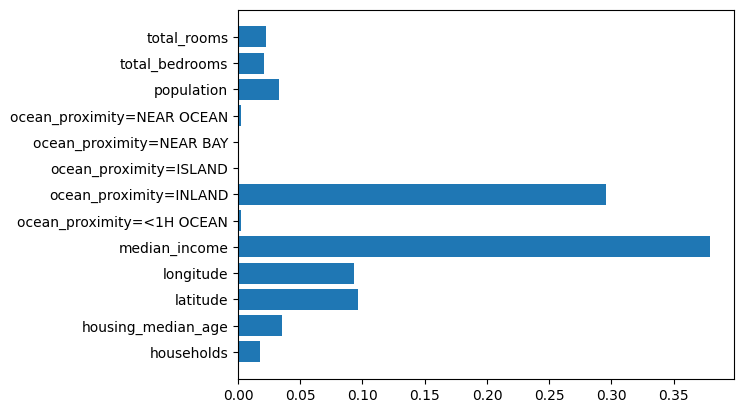

In [ ]:
plt.barh(dv.feature_names_, regr.feature_importances_)